# Softmax Regression Implementation
This notebook implements **Softmax Regression** from scratch and compares it with PyTorch's built-in implementation. It also includes **Learning Rate** and **Batch Size Analysis** to evaluate model performance and convergence behavior.

## 1. Import Required Libraries

In [12]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## 2. Softmax Regression (From Scratch)

In [13]:

class SoftmaxRegression:
    def __init__(self, input_dim, num_classes, lr=0.01):
        self.W = torch.zeros(input_dim, num_classes, dtype=torch.float32, requires_grad=True)
        self.b = torch.zeros(num_classes, dtype=torch.float32, requires_grad=True)
        self.lr = lr

    def softmax(self, z):
        exp_z = torch.exp(z - torch.max(z, dim=1, keepdim=True)[0])
        return exp_z / torch.sum(exp_z, dim=1, keepdim=True)

    def forward(self, X):
        return self.softmax(X @ self.W + self.b)

    def compute_loss(self, y_pred, y_true):
        batch_size = y_pred.shape[0]
        log_probs = -torch.log(y_pred[range(batch_size), y_true] + 1e-9)
        return torch.mean(log_probs)

    def update(self):
        with torch.no_grad():
            self.W -= self.lr * self.W.grad
            self.b -= self.lr * self.b.grad
            self.W.grad.zero_()
            self.b.grad.zero_()

    def train_model(self, train_loader, val_loader, epochs=50):
        train_losses, val_losses, train_accs, val_accs = [], [], [], []
        for _ in range(epochs):
            total_loss, correct, total = 0, 0, 0
            for X_batch, y_batch in train_loader:
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_pred, y_batch)
                loss.backward()
                self.update()
                total_loss += loss.item()
                correct += (y_pred.argmax(dim=1) == y_batch).sum().item()
                total += y_batch.size(0)
            train_loss = total_loss / len(train_loader)
            train_acc = correct / total
            val_loss, val_acc = self.evaluate(val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
        return train_losses, val_losses, train_accs, val_accs

    def evaluate(self, loader):
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_pred, y_batch)
                total_loss += loss.item()
                correct += (y_pred.argmax(dim=1) == y_batch).sum().item()
                total += y_batch.size(0)
        return total_loss / len(loader), correct / total

    def predict(self, loader):
        preds, labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in loader:
                y_pred = self.forward(X_batch)
                preds.extend(y_pred.argmax(dim=1).tolist())
                labels.extend(y_batch.tolist())
        return np.array(labels), np.array(preds)


## 3. PyTorch Built-in Softmax Model

In [14]:

class TorchSoftmaxModel:
    def __init__(self, input_dim, num_classes, lr=0.01):
        self.model = nn.Linear(input_dim, num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)

    def train_model(self, train_loader, val_loader, epochs=50):
        for _ in range(epochs):
            self.model.train()
            for X_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                logits = self.model(X_batch)
                loss = self.loss_fn(logits, y_batch)
                loss.backward()
                self.optimizer.step()

    def evaluate(self, loader):
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in loader:
                logits = self.model(X_batch)
                preds = torch.argmax(logits, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        return correct / total

    def predict(self, loader):
        preds, labels = [], []
        self.model.eval()
        with torch.no_grad():
            for X_batch, y_batch in loader:
                logits = self.model(X_batch)
                preds.extend(torch.argmax(logits, dim=1).tolist())
                labels.extend(y_batch.tolist())
        return np.array(labels), np.array(preds)


## 4. Helper Functions (Data Loading, Plotting, Metrics, Analysis)

In [15]:

def load_data(file_path, batch_size=64):
    data = pd.read_csv(file_path)
    Y = data['label'].values
    X = data.drop(columns=['label']).values / 255.0
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, stratify=Y, random_state=30)
    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=30)
    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(Y_train, dtype=torch.long)),
                              batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                          torch.tensor(Y_val, dtype=torch.long)),
                            batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(Y_test, dtype=torch.long)),
                             batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend(); plt.title('Loss over Epochs')
    plt.subplot(1,2,2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.legend(); plt.title('Accuracy over Epochs')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


def convergence_speed(val_losses):
    best_loss = val_losses[0]
    for i in range(1, len(val_losses)):
        if abs(val_losses[i] - best_loss) / best_loss < 0.001:
            return i
        best_loss = min(best_loss, val_losses[i])
    return len(val_losses)

def stability_measure(val_losses):
    tail = val_losses[-5:] if len(val_losses) >= 5 else val_losses
    return np.std(tail)

def gradient_noise_measure(train_losses):
    diffs = np.diff(train_losses)
    return np.var(diffs)


def run_learning_rate_analysis():
    train_loader, val_loader, _ = load_data("mnist_All.csv", batch_size=64)
    results = {}
    learning_rates = [0.001, 0.01, 0.1, 1.0]

    print("\n===== Learning Rate Analysis =====")
    for lr in learning_rates:
        print(f"\nTesting Learning Rate = {lr}")
        model = SoftmaxRegression(input_dim=784, num_classes=10, lr=lr)
        train_losses, val_losses, train_accs, val_accs = model.train_model(train_loader, val_loader, epochs=50)

        conv_speed = convergence_speed(val_losses)
        stability = stability_measure(val_losses)

        results[lr] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'convergence_speed': conv_speed,
            'stability': stability
        }

    best_lr = max(results, key=lambda x: max(results[x]['val_accs']))
    best_lr_acc = max(results[best_lr]['val_accs'])
    print(f"\nBest Learning Rate: {best_lr} (Validation Accuracy: {best_lr_acc:.4f})")

    return results, best_lr, best_lr_acc


def plot_learning_rate_analysis(results):
    plt.figure(figsize=(14, 10))
    plt.suptitle('Learning Rate Analysis', fontsize=14, fontweight='bold')

    plt.subplot(2, 2, 1)
    for lr, data in results.items():
        plt.plot(data['train_losses'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.subplot(2, 2, 2)
    for lr, data in results.items():
        plt.plot(data['val_losses'], label=f'LR={lr} (conv={data["convergence_speed"]}, stab={data["stability"]:.4f})')
    plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.subplot(2, 2, 3)
    for lr, data in results.items():
        plt.plot(data['train_accs'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.subplot(2, 2, 4)
    for lr, data in results.items():
        plt.plot(data['val_accs'], label=f'LR={lr}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def run_batch_size_analysis():
    results = {}
    batch_sizes = [16, 32, 64, 128]

    print("\n===== Batch Size Analysis =====")
    for bs in batch_sizes:
        print(f"\nTesting Batch Size = {bs}")
        train_loader, val_loader, _ = load_data("mnist_All.csv", batch_size=bs)
        model = SoftmaxRegression(input_dim=784, num_classes=10, lr=0.01)
        train_losses, val_losses, train_accs, val_accs = model.train_model(train_loader, val_loader, epochs=50)

        grad_noise = gradient_noise_measure(train_losses)

        results[bs] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accs,
            'val_accs': val_accs,
            'gradient_noise': grad_noise
        }

    best_bs = max(results, key=lambda x: max(results[x]['val_accs']))
    best_bs_acc = max(results[best_bs]['val_accs'])
    print(f"\nBest Batch Size: {best_bs} (Validation Accuracy: {best_bs_acc:.4f})")

    return results, best_bs, best_bs_acc


def plot_batch_size_analysis(results):
    plt.figure(figsize=(14, 10))
    plt.suptitle('Batch Size Analysis', fontsize=14, fontweight='bold')

    plt.subplot(2, 2, 1)
    for bs, data in results.items():
        plt.plot(data['train_losses'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Train Loss')
    plt.title('Train Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.subplot(2, 2, 2)
    for bs, data in results.items():
        plt.plot(data['val_losses'], label=f'BS={bs} (grad_noise={data["gradient_noise"]:.4f})')
    plt.xlabel('Epochs'); plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.subplot(2, 2, 3)
    for bs, data in results.items():
        plt.plot(data['train_accs'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.subplot(2, 2, 4)
    for bs, data in results.items():
        plt.plot(data['val_accs'], label=f'BS={bs}')
    plt.xlabel('Epochs'); plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs Epochs')
    plt.legend(fontsize=8); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## 5. Model Training, Evaluation (From Scratch)


Training Softmax Regression...


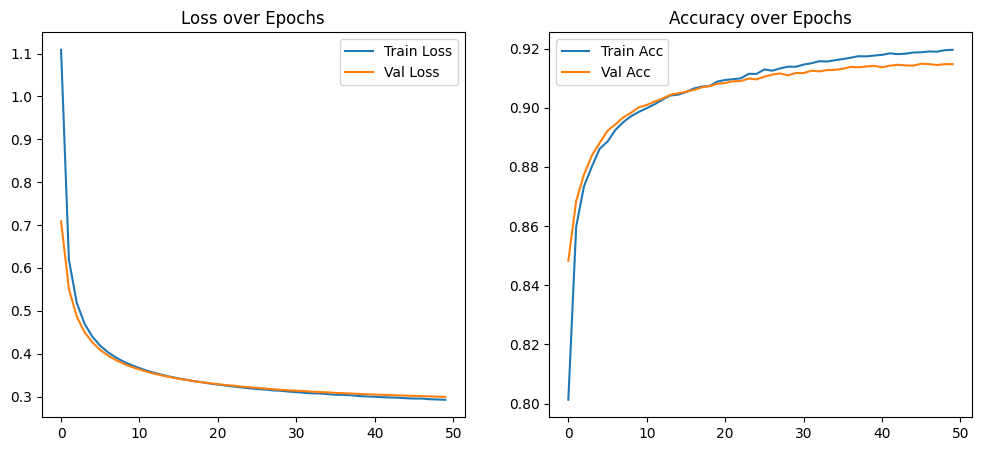


From-Scratch Test Accuracy: 0.9106


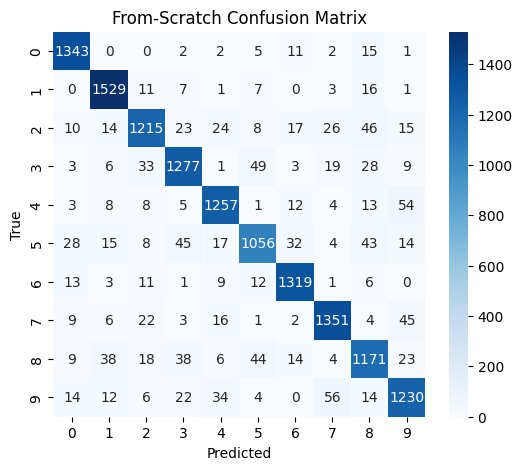


Per-Class Accuracy (From Scratch):

Class 0: 0.9725
Class 1: 0.9708
Class 2: 0.8691
Class 3: 0.8943
Class 4: 0.9209
Class 5: 0.8368
Class 6: 0.9593
Class 7: 0.9260
Class 8: 0.8579
Class 9: 0.8836


In [16]:
file_path = "mnist_All.csv"
train_loader, val_loader, test_loader = load_data(file_path)

print("\nTraining Softmax Regression...")
model_scratch = SoftmaxRegression(input_dim=784, num_classes=10, lr=0.01)
train_losses, val_losses, train_accs, val_accs = model_scratch.train_model(train_loader, val_loader, epochs=50)
plot_metrics(train_losses, val_losses, train_accs, val_accs)

test_loss, test_acc = model_scratch.evaluate(test_loader)
print(f"\nFrom-Scratch Test Accuracy: {test_acc:.4f}")
y_true_s, y_pred_s = model_scratch.predict(test_loader)
plot_confusion_matrix(y_true_s, y_pred_s, "From-Scratch Confusion Matrix")
print("\nPer-Class Accuracy (From Scratch):\n")
cm = confusion_matrix(y_true_s, y_pred_s)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_acc):
    print(f"Class {i}: {acc:.4f}")


## 6. Model Training, Evaluation, and Comparison (PyTorch)


Training PyTorch Built-in Softmax Regression...

PyTorch Built-in Test Accuracy: 0.9109


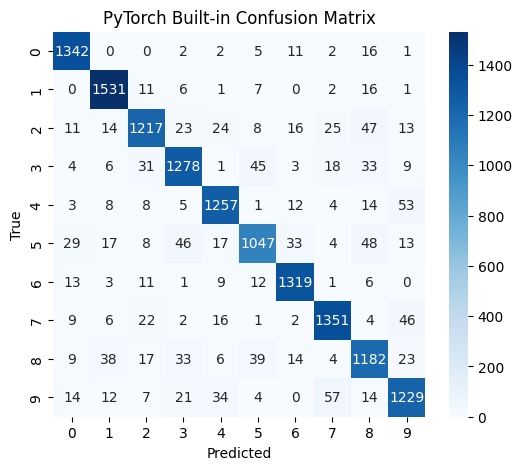


Per-Class Accuracy (PyTorch Built-in):

Class 0: 0.9718
Class 1: 0.9721
Class 2: 0.8705
Class 3: 0.8950
Class 4: 0.9209
Class 5: 0.8296
Class 6: 0.9593
Class 7: 0.9260
Class 8: 0.8659
Class 9: 0.8829

=== Final Comparison ===
From-Scratch Model Accuracy: 0.9106
PyTorch Built-in Model Accuracy: 0.9109


In [ ]:
print("\nTraining PyTorch Built-in Softmax Regression...")
model_torch = TorchSoftmaxModel(input_dim=784, num_classes=10, lr=0.01)
model_torch.train_model(train_loader, val_loader, epochs=50)
test_acc_t = model_torch.evaluate(test_loader)
print(f"\nPyTorch Built-in Test Accuracy: {test_acc_t:.4f}")
y_true_t, y_pred_t = model_torch.predict(test_loader)
plot_confusion_matrix(y_true_t, y_pred_t, "PyTorch Built-in Confusion Matrix")
print("\nPer-Class Accuracy (PyTorch Built-in):\n")
cm_t = confusion_matrix(y_true_t, y_pred_t)
per_class_acc_t = cm_t.diagonal() / cm_t.sum(axis=1)
for i, acc in enumerate(per_class_acc_t):
    print(f"Class {i}: {acc:.4f}")

print("\n=== Final Comparison ===")
print(f"From-Scratch Model Accuracy: {test_acc:.4f}")
print(f"PyTorch Built-in Model Accuracy: {test_acc_t:.4f}")


## 7. Learning Rate and Batch Size Analyisis


===== Learning Rate Analysis =====

Testing Learning Rate = 0.001

Testing Learning Rate = 0.01

Testing Learning Rate = 0.1

Testing Learning Rate = 1.0

Best Learning Rate: 0.1 (Validation Accuracy: 0.9232)


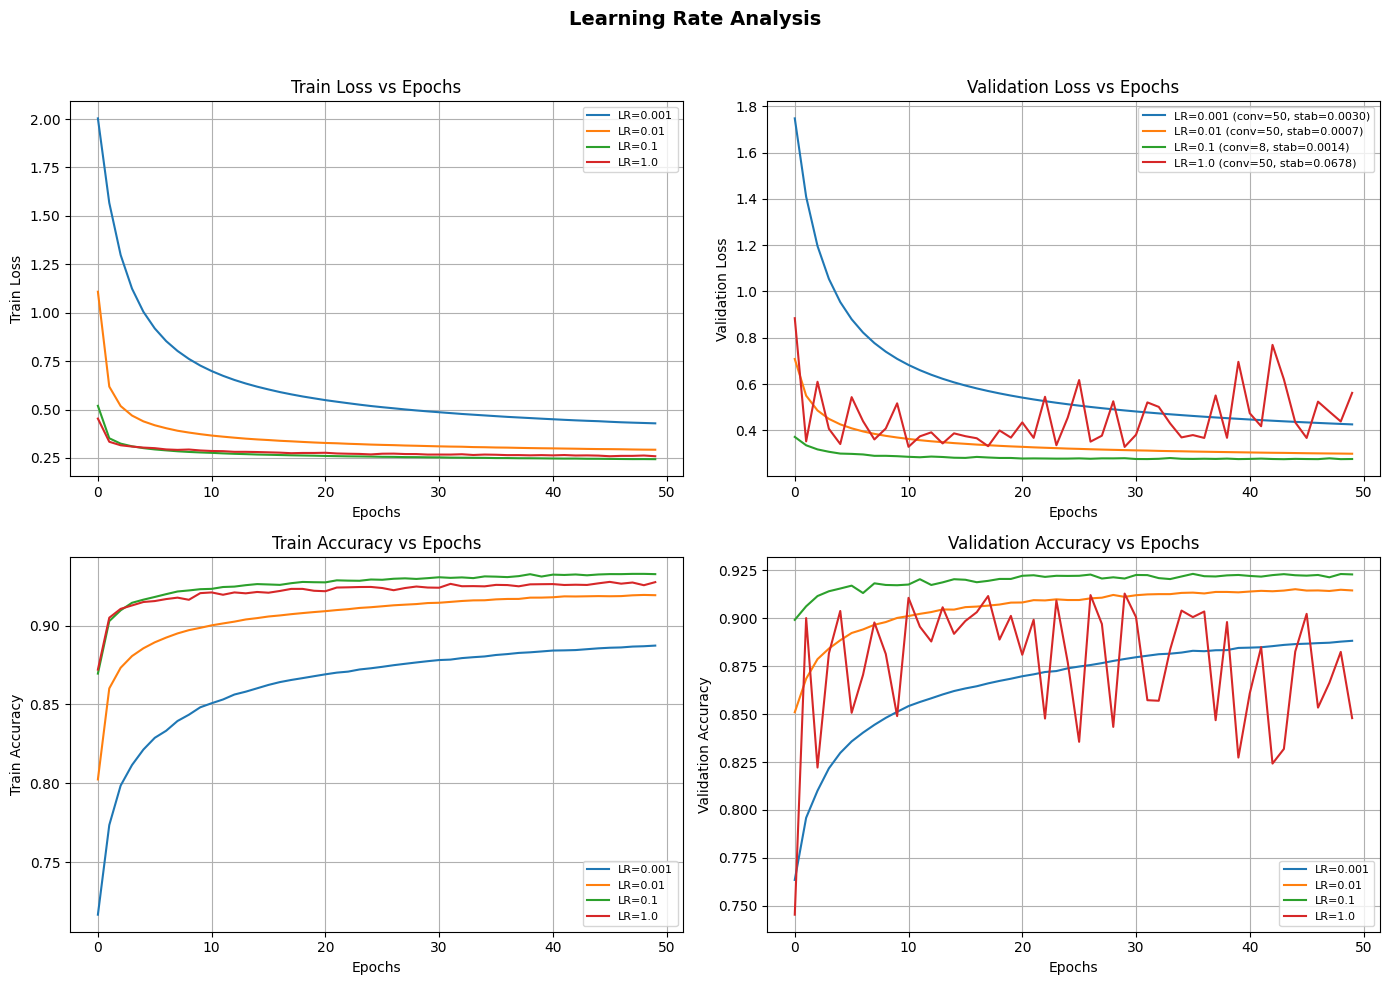


===== Batch Size Analysis =====

Testing Batch Size = 16

Testing Batch Size = 32

Testing Batch Size = 64

Testing Batch Size = 128

Best Batch Size: 16 (Validation Accuracy: 0.9219)


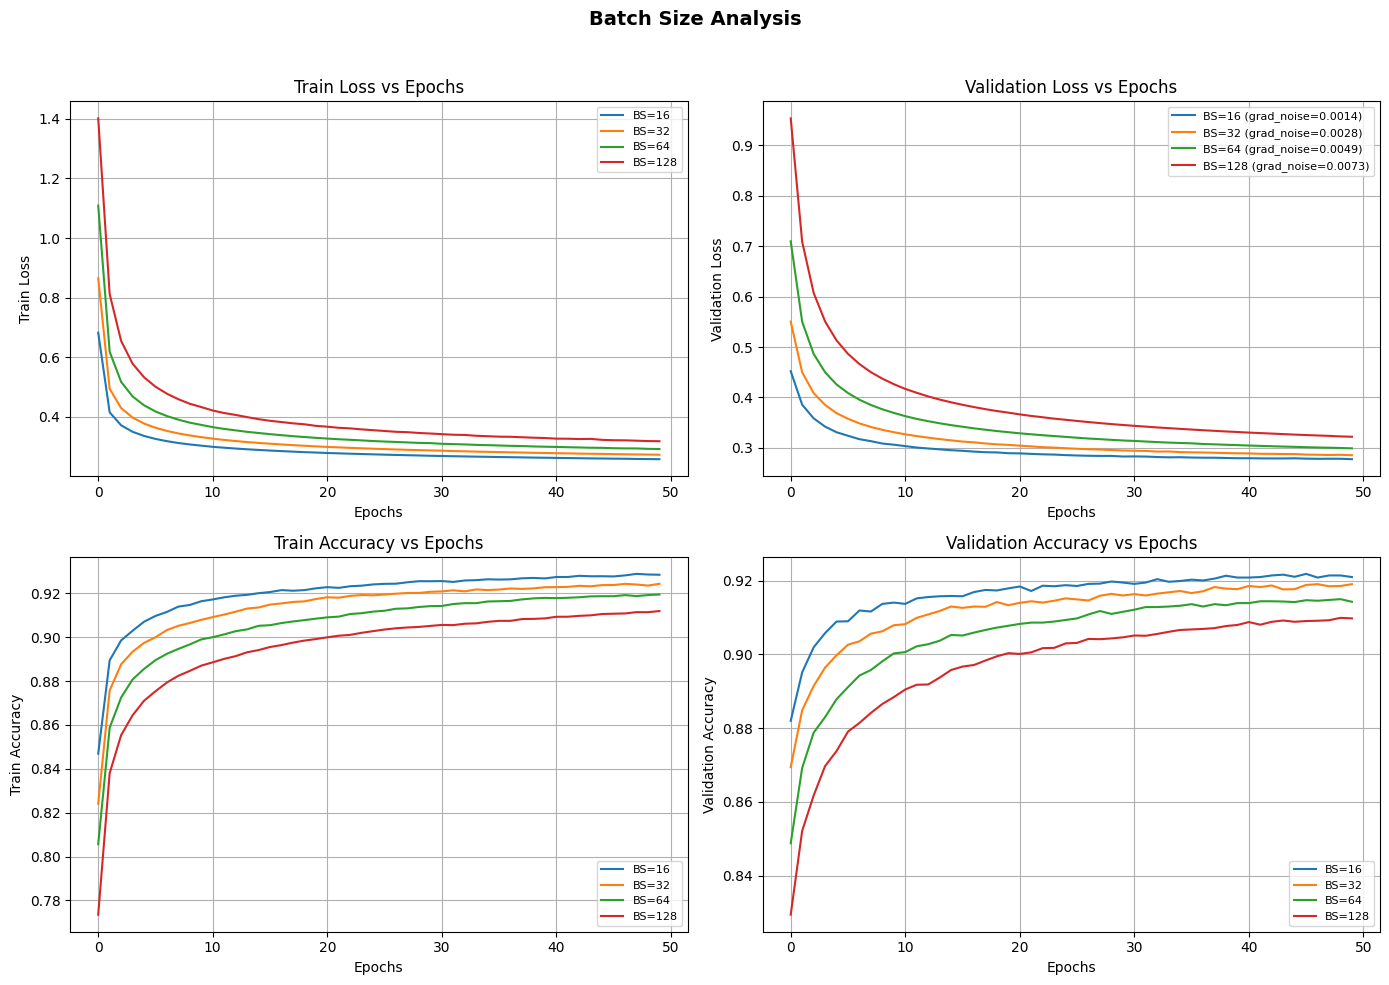

In [18]:
lr_results, best_lr, best_lr_acc = run_learning_rate_analysis()
plot_learning_rate_analysis(lr_results)

bs_results, best_bs, best_bs_acc = run_batch_size_analysis()
plot_batch_size_analysis(bs_results)


## 8. Analysis Results

In [3]:
def analyze_results(lr_results, bs_results):
    print("\n" + "="*60)
    print(" DETAILED ANALYSIS: LEARNING RATE & BATCH SIZE")
    print("="*60)

    print("\n LEARNING RATE ANALYSIS SUMMARY:")
    print(f"{'LR':<10} {'Best Val Acc':<15} {'Conv Speed':<15} {'Stability':<15}")
    print("-"*60)
    for lr, data in lr_results.items():
        best_val_acc = max(data['val_acc'])
        conv_speed = data['convergence_speed']
        stability = data['stability']
        print(f"{lr:<10} {best_val_acc:<15.4f} {conv_speed:<15} {stability:<15.6f}")



    print("\n BATCH SIZE ANALYSIS SUMMARY:")
    print(f"{'Batch Size':<15} {'Best Val Acc':<15} {'Grad Noise':<15}")
    print("-"*50)
    for bs, data in bs_results.items():
        best_val_acc = max(data['val_acc'])
        grad_noise = data['gradient_noise']
        print(f"{bs:<15} {best_val_acc:<15.4f} {grad_noise:<15.6f}")
    

In [ ]:
analyze_results(lr_results, bs_results)